In [1]:
from sklearn.ensemble import RandomForestRegressor
from deconfounder.mse_causal import CausalCriterion
import pandas as pd
import numpy as np

class CausalForest(RandomForestRegressor):

    def fit(self, X, y, sample_weight=None):
        """
        Replaces the string stored in criterion by an instance of a class.
        """
        self.criterion = CausalCriterion(1, X.shape[0])
        treated = X.treated.values.astype(int)
        self.criterion.set_treated(treated)
        X_base = X.loc[:, X.columns != 'treated']
        RandomForestRegressor.fit(self, X_base, y, sample_weight=sample_weight)
        return self

    def predict(self, X):
        X_base = X.loc[:, X.columns != 'treated']
        return RandomForestRegressor.predict(self, X_base)

    def score(self, X, y,  sample_weight=None):
        # This method does not support sample_weight
        X_base = X.loc[:, X.columns != "treated"]
        node_pred = self.apply(X_base)
        df = pd.DataFrame()
        df['node'] = node_pred
        df['treated'] = X.treated.values > 0
        df['y'] = np.array(y)
        treated_groups = df[df.treated].groupby('node').y
        untreated_groups = df[~df.treated].groupby('node').y
        # For more details about the formula, take a look at page 7357 (page 5) of the Athey & Imbens PNAS paper (Causal Tree)
        test_effs_hat = (treated_groups.mean() - untreated_groups.mean())[df.node]
        model_effs_hat = self.predict(X_base)
        mse = -2 * (test_effs_hat * model_effs_hat).mean() + np.square(model_effs_hat).mean()
        return -mse

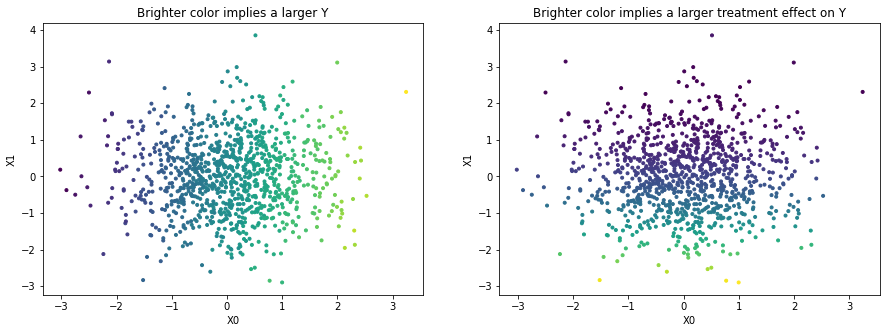

,0,1,treated
0,0.496714,-0.138264,False
1,-0.234153,-0.234137,False
2,-0.469474,0.542560,True
3,0.241962,-1.913280,True
4,-1.012831,0.314247,True


In [2]:
# MODULE IMPORTS
import os
import sys
sys.path.append("..")
from deconfounder.causal_tree import CausalTree
# OTHER IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from numpy.polynomial.polynomial import polyfit
import pandas as pd
from sklearn.model_selection import train_test_split

np.random.seed(42)
X = np.random.normal(size=(1000,4))
alpha = [16, -8]
t = (X[:, 0] + X[:, 3] * 0.5) > 0
switch = np.zeros(X.shape[0])
switch[t] = 1
treated = np.random.binomial(1, 0.5, X.shape[0])> 0
effs = X[:, 1]**2 - X[:, 1]*5
y = X[:, 0]*40 + effs*treated + X[:, 2]*2

fig, ax = plt.subplots(1, 2, figsize=(15,5))
# Plot outcomes in terms of features
ax[0].scatter(X[:, 0], X[:, 1], c=y, marker=".")
ax[0].set_title("Brighter color implies a larger Y")
ax[0].set_xlabel("X0")
ax[0].set_ylabel("X1")
# Plot effects in terms of features
ax[1].scatter(X[:, 0], X[:, 1], c=effs, marker=".")
ax[1].set_title("Brighter color implies a larger treatment effect on Y")
ax[1].set_xlabel("X0")
ax[1].set_ylabel("X1")

plt.show()

df_full = pd.DataFrame(X)
df_full['treated'] = treated
df = df_full.iloc[:, [0, 1, 4]]
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)
effs_test = effs[X_test.index.values]
df.head()

In [3]:
causal_model = CausalForest(min_samples_leaf=10, random_state=42, n_estimators=10)
causal_model.fit(X_train, y_train)
pred = causal_model.predict(X_test)

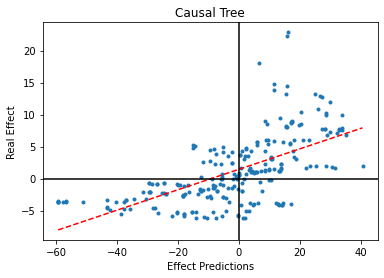

In [4]:
def plot_causal_tree_results(pred):
    fig, ax = plt.subplots(1, 1)
    ax.plot(pred, effs_test, ".")
    # Regression line
    b, m = polyfit(pred, effs_test, 1)
    sorted_pred = np.sort(pred)
    reg_line = b + m*sorted_pred
    ax.plot(sorted_pred, reg_line, "--", color='red')
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    # Format chart
    ax.set_title("Causal Tree")
    ax.set_xlabel("Effect Predictions")
    ax.set_ylabel("Real Effect")
    plt.show()
    
plot_causal_tree_results(pred)